 
# Kaggle: Image Segmentation
# Enrollment Roll Number:

# 1. 19BCE038
# 2. 19BCE040

In [1]:
import numpy as np 
import pandas as pd
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
EPOCHS=20
BATCH_SIZE=32
HEIGHT=256
WIDTH=256
CHANNELS=3
N_CLASSES=13
AUTO = tf.data.AUTOTUNE

# Utility functions

In [3]:
def loadImage(path):
    img = Image.open(path)
    img = np.array(img)
    
    image = img[:,:256]
    image = image / 255.0
    mask = img[:,256:]
    
    return image, mask

def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [4]:
train_folder = "../input/cityscapes-image-pairs/cityscapes_data/train"
valid_folder = "../input/cityscapes-image-pairs/cityscapes_data/val"
train_filenames = glob.glob(os.path.join(train_folder, "*.jpg"))
valid_filenames = glob.glob(os.path.join(valid_folder, "*.jpg"))

num_of_training_samples = len(train_filenames) 
num_of_valid_samples = len(valid_filenames)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.filenames = filenames
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for file in batches:
            image, mask = loadImage(file)
            mask_binned = bin_image(mask)
            labels = getSegmentationArr(mask_binned, N_CLASSES)
            labels = np.argmax(labels, axis=-1)

            imgs.append(image)
            segs.append(labels)

        return np.array(imgs), np.array(segs)

    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [5]:
train_gen = DataGenerator(train_filenames)
val_gen = DataGenerator(valid_filenames)

In [6]:
for imgs, segs in train_gen:
    break
imgs.shape, segs.shape

((32, 256, 256, 3), (32, 256, 256))

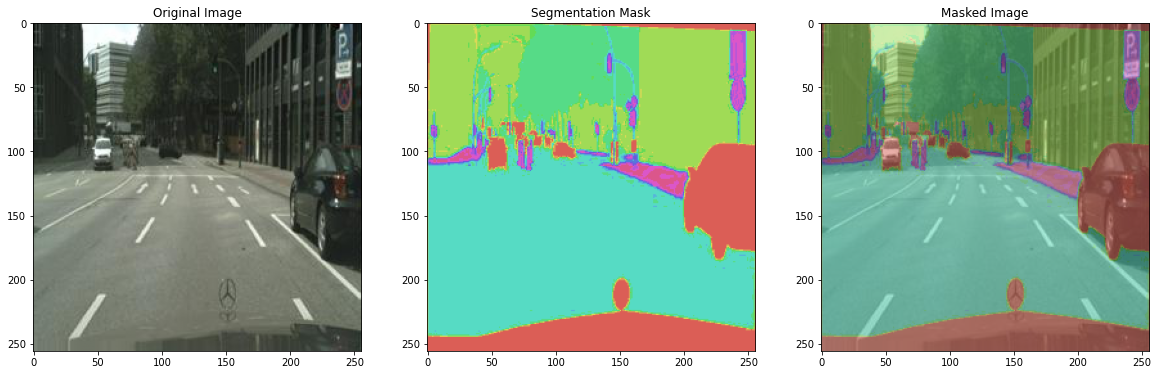

In [7]:
image = imgs[0]
mask = give_color_to_seg_img(segs[0])
masked_image = image * 0.5 + mask * 0.5

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

# Loss function

In [8]:
smooth = 1

def dice_coef(y_true, y_pred):
    And = tf.reduce_sum(y_true * y_pred)
    return (2 * And + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

# Model

In [9]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPooling2D((2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [10]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT,WIDTH,3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [11]:
def unet():
    main_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img_input')

    ''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(main_input)
    c1 = LeakyReLU(0.2)(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c1)
    c1 = LeakyReLU(0.2)(c1)
    c1 = BatchNormalization()(c1)

    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(p1)
    c2 = LeakyReLU(0.2)(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c2)
    c2 = LeakyReLU(0.2)(c2)
    c2 = BatchNormalization()(c2)

    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(p2)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*2, kernel_size=(1,1), padding = 'same')(c3)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c3)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)

    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p3)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*4, kernel_size=(1,1), padding = 'same')(c4)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(c4)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)

    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p4)
    c5 = LeakyReLU(0.2)(c5)
    c5 = BatchNormalization()(c5)


    ''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    u1 = UpSampling2D((2,2))(c5)
    concat1 = concatenate([c4, u1])

    c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(concat1)
    c6 = LeakyReLU(0.2)(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c6)
    c6 = LeakyReLU(0.2)(c6)
    c6 = BatchNormalization()(c6)


    u2 = UpSampling2D((2,2))(c6)
    concat2 = concatenate([c3, u2])

    c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(concat2)
    c7 = LeakyReLU(0.2)(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c7)
    c7 = LeakyReLU(0.2)(c7)
    c7 = BatchNormalization()(c7)

    u3 = UpSampling2D((2,2))(c7)
    concat3 = concatenate([c2, u3])

    c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(concat3)
    c8 = LeakyReLU(0.2)(c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c8)
    c8 = LeakyReLU(0.2)(c8)
    c8 = BatchNormalization()(c8)

    u4 = UpSampling2D((2,2))(c8)
    concat4 = concatenate([c1, u4])

    c9 = Conv2D(16, kernel_size = (1,1), padding = 'same')(concat4)
    c9 = LeakyReLU(0.2)(c9)
    c9 = BatchNormalization()(c9)

    mask_out = Conv2D(N_CLASSES, (1,1), padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)

    model = Model(inputs = [main_input], outputs = [mask_out])
    
    return model

In [12]:
model = unet()
model.summary()

2022-05-06 06:36:05.250690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 06:36:05.365847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 06:36:05.366669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 06:36:05.367791: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         img_input[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Callbacks

In [13]:
checkpoint = ModelCheckpoint('seg_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# Training

In [14]:
TRAIN_STEPS = len(train_gen)
VAL_STEPS = len(val_gen)

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
          validation_steps=VAL_STEPS, epochs=EPOCHS, callbacks = [checkpoint])

2022-05-06 06:36:08.599007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-06 06:36:12.059982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


92/92 [==============================] - 69s 643ms/step - loss: 1.3373 - accuracy: 0.6593 - val_loss: 4.9399 - val_accuracy: 0.3414

Epoch 00001: val_loss improved from inf to 4.93994, saving model to seg_model.h5
Epoch 2/20
92/92 [==============================] - 50s 545ms/step - loss: 0.9636 - accuracy: 0.7459 - val_loss: 3.7713 - val_accuracy: 0.3291

Epoch 00002: val_loss improved from 4.93994 to 3.77130, saving model to seg_model.h5
Epoch 3/20
92/92 [==============================] - 50s 541ms/step - loss: 0.8572 - accuracy: 0.7662 - val_loss: 3.9324 - val_accuracy: 0.3338

Epoch 00003: val_loss did not improve from 3.77130
Epoch 4/20
92/92 [==============================] - 49s 532ms/step - loss: 0.8133 - accuracy: 0.7735 - val_loss: 2.9305 - val_accuracy: 0.4261

Epoch 00004: val_loss improved from 3.77130 to 2.93046, saving model to seg_model.h5
Epoch 5/20
92/92 [==============================] - 50s 540ms/step - loss: 0.7689 - accuracy: 0.7826 - val_loss: 2.1337 - val_accurac

In [15]:
learning_rate = 1e-4
decay_rate = (learning_rate - 1e-6) / 100
opt = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

checkpoint = ModelCheckpoint('seg_model_v2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history2 = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
          validation_steps=VAL_STEPS, epochs=10, callbacks = [checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
92/92 [==============================] - 52s 542ms/step - loss: 0.5311 - accuracy: 0.8363 - val_loss: 0.6807 - val_accuracy: 0.8004

Epoch 00001: val_loss improved from inf to 0.68066, saving model to seg_model_v2.h5
Epoch 2/10
92/92 [==============================] - 49s 530ms/step - loss: 0.5202 - accuracy: 0.8392 - val_loss: 0.6863 - val_accuracy: 0.7988

Epoch 00002: val_loss did not improve from 0.68066
Epoch 3/10
92/92 [==============================] - 49s 535ms/step - loss: 0.5157 - accuracy: 0.8402 - val_loss: 0.7022 - val_accuracy: 0.7979

Epoch 00003: val_loss did not improve from 0.68066
Epoch 4/10
92/92 [==============================] - 49s 535ms/step - loss: 0.5090 - accuracy: 0.8420 - val_loss: 0.6944 - val_accuracy: 0.8012

Epoch 00004: val_loss did not improve from 0.68066
Epoch 5/10
92/92 [==============================] - 49s 532ms/step - loss: 0.5063 - accuracy: 0.8425 - val_loss: 0.6973 - val_accuracy: 0.7956

Epoch 00005: val_loss did not improve from 

# Train History

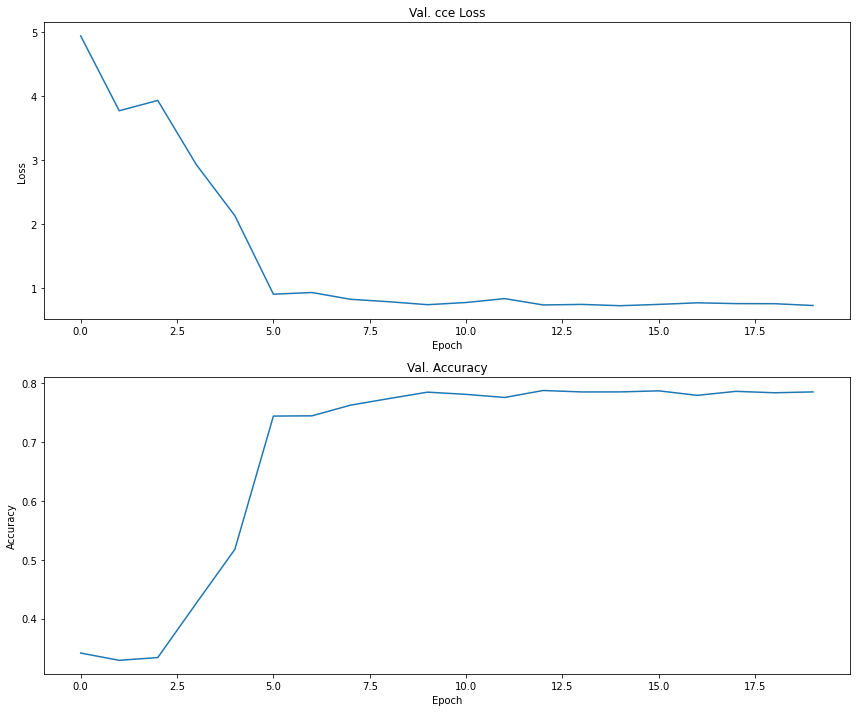

In [16]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"]

plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.title("Val. cce Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Visualize outputs

In [17]:
model.load_weights("./seg_model_v2.h5")

In [18]:
test_gen = DataGenerator(valid_filenames, 1)

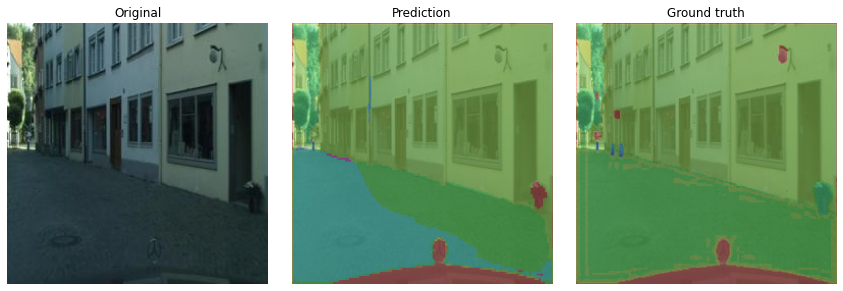

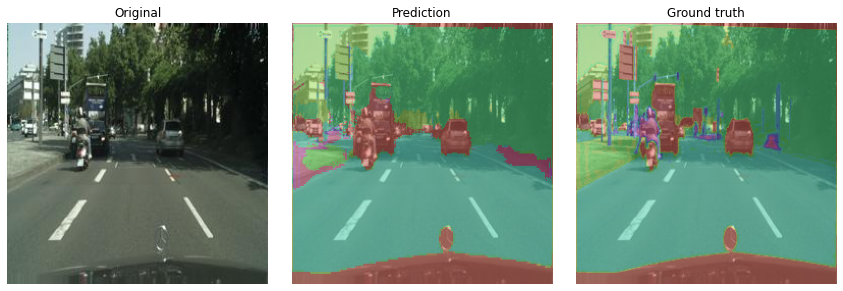

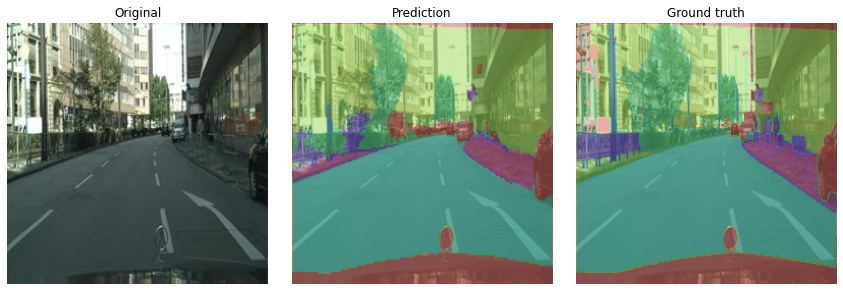

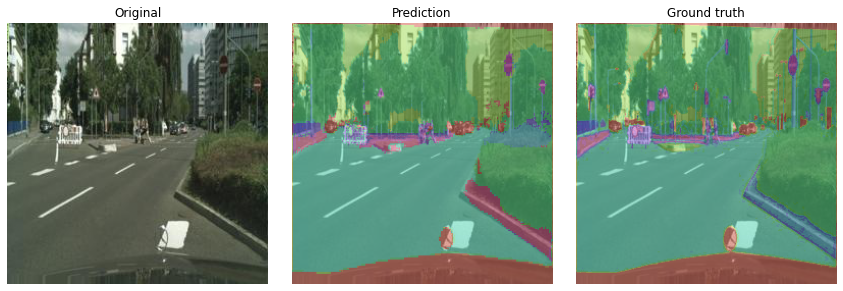

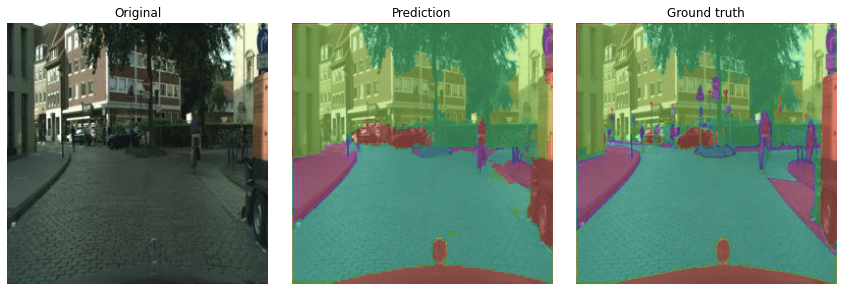

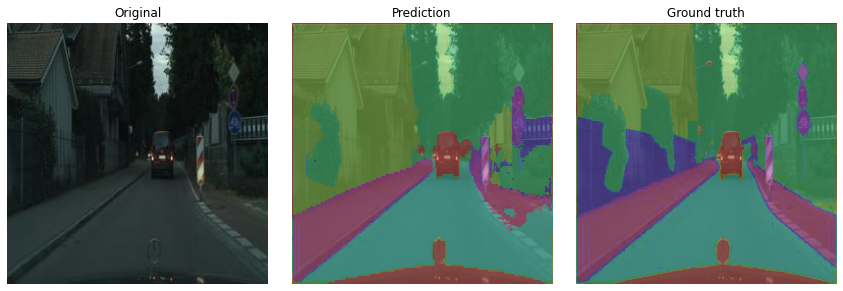

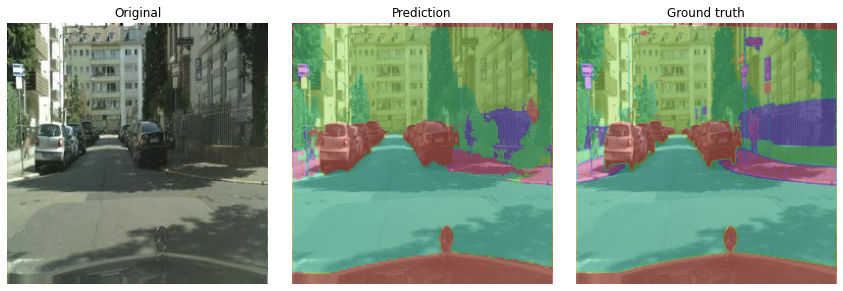

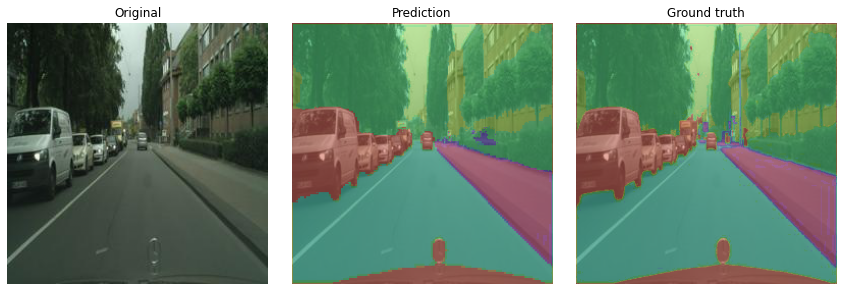

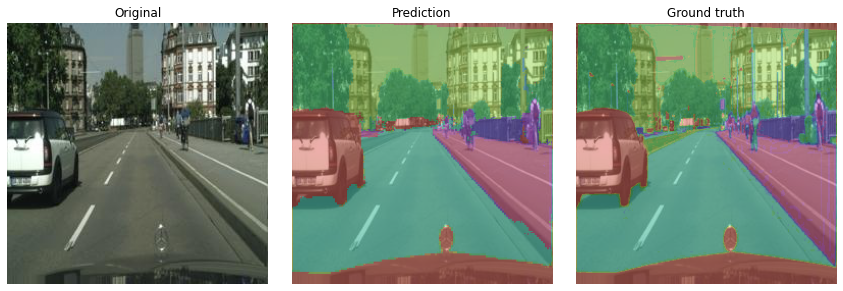

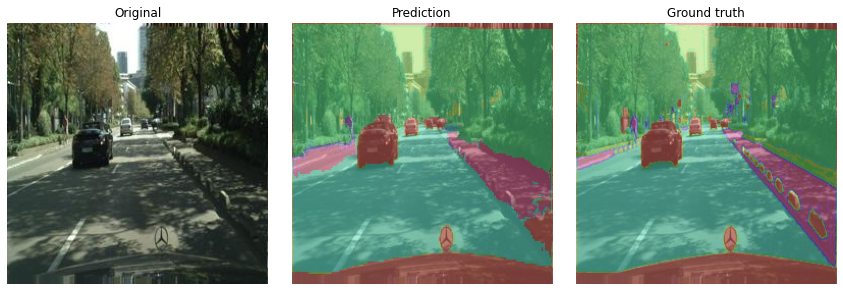

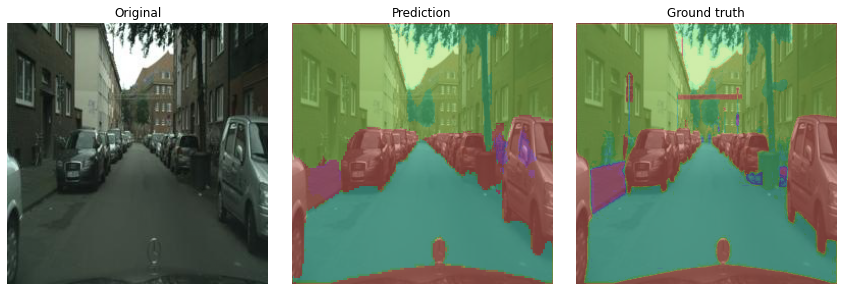

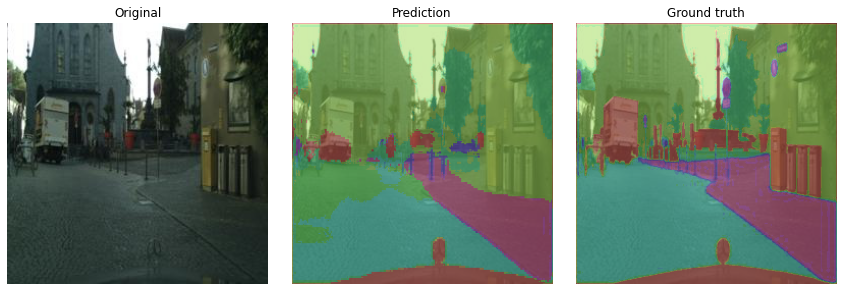

In [19]:
test_iter = iter(test_gen)
for i in range(12):
    imgs, segs = next(test_iter)
    pred = model.predict(imgs)
    _p = give_color_to_seg_img(np.argmax(pred[0], axis=-1))
    _s = give_color_to_seg_img(segs[0])

    predimg = cv2.addWeighted(imgs[0], 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[0], 0.5, _s, 0.5, 0)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(imgs[0])
    plt.axis("off")
    
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title("Ground truth")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()